References:

1) https://www.neuron.yale.edu/neuron/static/new_doc/programming/hocsyntax.html

2) https://www.neuron.yale.edu/neuron/static/new_doc/programming/python.html

3) https://www.neuron.yale.edu/neuron/static/py_doc/programming/python.html

4) https://www.geeksforgeeks.org/single-neuron-neural-network-python/

5) https://github.com/piazentin/ksets

6) AP - https://www.moleculardevices.com/applications/
patch-clamp-electrophysiology/what-action-potential#gref

7) https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/network/netcon.html

8) http://neupy.com/apidocs/neupy.algorithms.associative.hebb.html

9) https://qbi-software.github.io/NEURON-tutorial/lessons/network

10) https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/topology/geometry.html

11) http://www.cnel.ufl.edu/courses/EEL6814/chapter6.pdf

12) https://www.slideshare.net/mentelibre/hebbian-learning

13) http://www.diva-portal.org/smash/get/diva2:1089220/FULLTEXT02

In [56]:
pip install neuron

## Move nvninmodl files to curr_dir (for ORN)


In [57]:
# from google.colab import drive
# drive.mount('/content/drive')

In [58]:
# !ls /content/drive/My\ Drive/nrnmodl/
# !cp /content/drive/My\ Drive/nrnmodl/* /content

In [59]:
# !pwd

In [60]:
# !nrnivmodl

**Stage 1:Importing required libraries**

In [61]:
from neuron import h                     #.h is a HOC object instanced & gui from neuron can also be imported 
from neuron.units import ms,mV
h.load_file('stdrun.hoc')                #Allows us to do a high level simulation
  
import matplotlib.pyplot as plt1

import numpy as np
from scipy.stats import poisson
import seaborn as sb

from bokeh.io import output_notebook
import bokeh.plotting as plt2
output_notebook()

# import logging
# logging.basicConfig(level=logging.DEBUG)

# size=int(input('Enter no.of sets  '))
size = 15

In [62]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

### **Stage 2:Making a Neuron with specific properties**

In [63]:
# #This is the ORN class
# class ORN:
#     def __init__(self,gid,M):
#         self._gid = gid
#         self.M = M+1

#         # Set morphology
#         self.soma = h.Section(name='soma', cell=self)
#         self.axon = h.Section(name='axon', cell=self)
#         self.dendArr = [h.Section(name="dend%d" % i, cell=self) for i in range(1)]
#         self.dendriticknobArr = [h.Section(name="dendriticknob%d" % i, cell=self) for i in range(1)]
#         self.ciliumArr = [h.Section(name="cilium%d" % i, cell=self) for i in range(1)]

#         self.axon.connect(self.soma(0),0)
#         self.dendArr[0].connect(self.soma(1),0)
#         self.dendriticknobArr[0].connect(self.dendArr[0](0),1)
        
#         self.dendriticknobArr[0].nseg = 1
#         self.dendriticknobArr[0].diam = 2
#         self.dendriticknobArr[0].L = 2
#         self.dendriticknobArr[0].insert('ciliaProp')

#         for i in range(1):
#             self.ciliumArr[i].connect(self.dendriticknobArr[0](1),0)

# #         self._spike_detector = h.NetCon(self.axon(0.5)._ref_v, None, sec=self.axon)
# #         self.spike_times = h.Vector()
# #         self._spike_detector.record(self.spike_times)
# #         self.axon_v = h.Vector().record(self.axon(0.5)._ref_v)
# #         self._ncs = [] 

#         # anatomical and biophysical properties
#         self.soma.nseg = 1 
#         self.soma.L = 9 # micrometer
#         self.soma.diam = 6
#         self.soma.insert('hh1')

#         self.axon.nseg = 1
#         self.axon.L = 100
#         self.axon.diam = 1
#         self.axon.insert('hh')
    
#         self.dendArr[0].nseg = 1
#         self.dendArr[0].L = 50
#         self.dendArr[0].diam = 1.5
#         self.dendArr[0].insert('dendProp')
#         # self.dendArr[0].e_pas = -65
#         # self.dendArr[0].g_pas = 0.001

#         for i in range(1):
#             self.ciliumArr[i].nseg = 1
#             self.ciliumArr[i].diam = 0.28
#             self.ciliumArr[i].L = 200
#             self.ciliumArr[i].insert("blr300%d" % i)

#         self.tstop = 6
        
#     def __repr__(self):
#         return 'Set [{}]_ORNcell [{}]'.format(self.M,self._gid)
#         #This shows how to represent each part when called upon

In [64]:
#This class makes one cell neuron(soma,axon,dendrite)
class MCELL:
    def __init__(self, gid, M):
        self._gid = gid #Neuron no.
        self.M = M+1
        #Setting morphology
        #Creating soma,dend and axon
        self.soma=h.Section(name='soma',cell=self)
        self.dend=h.Section(name='dend',cell=self)
        self.axon=h.Section(name='axon',cell=self)
        
        self.all = [self.axon, self.soma, self.dend] 
        #list of all the sections in the cell.
        #We could explicitly specify the connection location  by self.dend.connect(self.soma(0.5))
        
        self.dend.connect(self.soma,1,0)
        self.axon.connect(self.soma,0,0)
        
        self._spike_detector = h.NetCon(self.axon(0.5)._ref_v, None, sec=self.axon)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)
        self.axon_v = h.Vector().record(self.axon(0.5)._ref_v)
        self._ncs = [] 
        
        #Defining geometry of soma
        self.soma.L = 18.8 
        self.soma.diam = 18.8 #in microns
        self.soma.nseg = 1                  #No. of segments
        
        #Defining geometry of dend
        self.dend.nseg = 1                  #No. of segments
        self.dend.L = 701.9                 #in microns
        self.dend.diam = 3.18                #in microns
        self.dendexcisyn = h.ExpSyn(self.dend(0.5))
        self.dendexcisyn.tau = 1 *ms   # tau is decay time constant
        self.dendexcisyn.e = 0    # reversal potential
        
        #Defining geometry for axon
        self.axon.nseg = 1
        self.axon.L = 152
        self.axon.diam = 3.18
        
        #Setting biophysics
        for sec in self.all:                                                  
            sec.Ra = 123    # Axial resistance in Ohm * cm                    
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        
        self.soma.insert('hh')            #Inserting HH neurons
        self.axon.insert('hh')
        self.dend.insert('pas')
        for seg in self.dend:                               
            seg.pas.g = 0.001  # Passive conductance in S/cm2 
            seg.pas.e = -78    # Leak reversal potential mV
        
    def __repr__(self):
        return 'Set [{}]_Mcell [{}]'.format(self.M,self._gid)
        #This shows how to represent each part when called upon

**Normal Distribution**

In [65]:
# from scipy.stats import uniform
# label=['Pdf','Histogram']
mean, SD = 1, 0.5
normal_distribution = np.random.normal(mean, SD,2*size-1)
print(normal_distribution)
# Create the bins and histogram
# count, bins, ignored = plt1.hist(uniform_distribution,10)
# #plt1.plot(bins, np.ones_like(bins), linewidth=2, color='r')
# plt1.plot(bins,uniform.pdf(bins))
# plt1.legend(label)
# plt1.xlabel('weights')
# plt1.ylabel('frequency')
# plt1.grid()
# plt1.show()
# print(uniform_distribution)

[0.91326284 1.51755467 1.22524769 0.88794072 0.90699514 1.10475341
 0.83169984 0.43404924 0.83374552 0.93399518 1.07642453 1.32485511
 0.97448468 1.9925995  0.44296773 0.51067497 0.86566101 1.08041855
 1.63592384 0.50921576 1.62875053 0.99528526 1.41276763 0.72958935
 1.00778162 1.33007447 1.26391083 2.07508643 2.1399906 ]


In [66]:
weights = normal_distribution
print(weights)

[0.91326284 1.51755467 1.22524769 0.88794072 0.90699514 1.10475341
 0.83169984 0.43404924 0.83374552 0.93399518 1.07642453 1.32485511
 0.97448468 1.9925995  0.44296773 0.51067497 0.86566101 1.08041855
 1.63592384 0.50921576 1.62875053 0.99528526 1.41276763 0.72958935
 1.00778162 1.33007447 1.26391083 2.07508643 2.1399906 ]


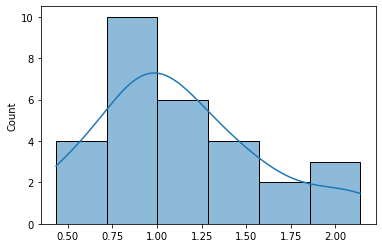

In [67]:
sb.histplot(weights, kde=True)

## **Stage 3.5 : Make different sorts of inputs**

In [68]:
def stairstep(lo: float, hi: float, duration: int, max_duration: int = 200, noise: list = []) -> list:
    # duration and max_duration are in ms
    ans = [lo if i < duration else hi for i in range(0,max_duration)]
    if len(noise) == 0:
        return ans
    else:
        assert len(ans) == len(noise)
        return [ans[i]+noise[i] for i in range(len(ans))]
    # return [0+0.8*(i/duration) if i < duration else 0 for i in range(0,max_duration)]
    # visualize input 

**Stage 4: Coupling a neuron according to Freeman's KI Set with the weights given above**

In [69]:
#Gives one 2 coupled neuron using freeman's topology in olfactory bulb
class CONNECTING:

    def __init__(self,M,weights,delay1=1,delay2=1):
        wMM=weights[0]
        
        self.M = M #Set no.
        self.th = -70
        self.maindelay = 0
        
        #Making 2 neurons
        self.cells=[]
        self.P1=MCELL(1,self.M)
        self.P2=MCELL(2,self.M)
        self.cells.append(self.P1)
        self.cells.append(self.P2)
        
        #Giving current pulse
        self.stim = h.IClamp(self.P1.dend(0.5))
        self.noise = np.random.normal(0, 0.01, 100)
        self.input = h.Vector(stairstep(0,1,10,100,self.noise))
        self.tv = h.Vector([i for i in range(100)])
        self.stim.delay = 10
        self.stim.dur = 101
        self.stim.amp = 0
        self.input.play(self.stim._ref_amp, self.tv, True) 
        
                
        #Connecting P1 to P2
        self.nc1 = h.NetCon(self.P1.axon(0.5)._ref_v,self.P2.dendexcisyn,sec=self.P1.axon)   # P1.axon to P2.dend
        self.nc1.weight[0] = weights[M]
        print("mutual weight is ", weights[M])
        self.nc1.delay = 0.1 #tP1P2
        self.nc1.threshold = self.th
        
        #Connecting P2 to P1
        self.nc2 = h.NetCon(self.P2.axon(0.5)._ref_v,self.P1.dendexcisyn,sec=self.P2.axon)    #P2.axon to P1.dend
        self.nc2.weight[0] = weights[M]
        self.nc2.delay = 0.3 #tP2P1
        self.nc2.threshold = self.th    

            

**Stage 5: Laterally connect each set of 2 coupled neurons according to Freeman's KI Set**

In [70]:
class LATERAL:

    def __init__(self,N,weights):
        wMML=weights
        #wMML=0.1
        
        self.N = N
        self.th = -70
        self.maindelay = 20
        self.sets = []
        c=0
        for i in range(N):
            self.sets.append(CONNECTING(i,weights))
        
        self.netConArr = []
        for r in range(0,N-1):
          #Connecting P1[0] to P1[1]
          # make a list for easier access
          netConList = []
          netConList.append(h.NetCon(self.sets[r].P1.axon(0.5)._ref_v, self.sets[r+1].P1.dendexcisyn,sec=self.sets[r].P1.axon))
          netConList[0].weight[0]  = wMML[r+N]
          print("Lateral weight is", wMML[r+N])
          netConList[0].delay = self.maindelay+1
          netConList[0].threshold = self.th

          netConList.append(h.NetCon(self.sets[r+1].P1.axon(0.5)._ref_v, self.sets[r].P1.dendexcisyn, sec=self.sets[r+1].P1.axon))
          netConList[1].weight[0] = wMML[r+N]
          netConList[1].delay = self.maindelay+2
          netConList[1].threshold = self.th

          self.netConArr.append(netConList)

          # exec(f"self.nc11_{r} = h.NetCon(getattr(self.sets[r].P1.axon(0.5), '_ref_v'), self.sets[1+r].P1.dendexcisyn,sec=self.sets[r].P1.axon)")
          # exec(f"self.nc11_{r}.weight[0] = wMML[r+N]")
          # print("lateral weight is", wMML[r+N])
          # exec(f"self.nc11_{r}.delay = self.maindelay+1")
          # exec(f"self.nc11_{r}.threshold = self.th")
          # exec(f"self.nc12_{r} = h.NetCon(getattr(self.sets[1+r].P1.axon(0.5), '_ref_v'), self.sets[r].P1.dendexcisyn,sec=self.sets[1+r].P1.axon)")
          # exec(f"self.nc12_{r}.weight[0] = wMML[r+N]")
          # #print(wMML[r+N])
          # exec(f"self.nc12_{r}.delay = self.maindelay+2")
          # exec(f"self.nc12_{r}.threshold = self.th")

**Stage 6: Input the number of 2 coupled sets required (which are all laterally connected)**

In [71]:
#Give N value to get N no. of 2 coupled neurons laterally connected
given_input_from_user =size #  int(input('Enter the number of 2 coupled sets required: '))
L1=LATERAL(given_input_from_user,weights)
print(weights)

mutual weight is  0.913262837468169
mutual weight is  1.517554674220733
mutual weight is  1.2252476892845023
mutual weight is  0.8879407241304598
mutual weight is  0.9069951388738355
mutual weight is  1.1047534140237414
mutual weight is  0.8316998358678683
mutual weight is  0.4340492391911155
mutual weight is  0.8337455198140882
mutual weight is  0.9339951847965785
mutual weight is  1.0764245252062183
mutual weight is  1.324855112136036
mutual weight is  0.9744846758794361
mutual weight is  1.9925994969116263
mutual weight is  0.4429677313761876
Lateral weight is 0.5106749747221149
Lateral weight is 0.8656610101317592
Lateral weight is 1.0804185456456483
Lateral weight is 1.6359238385679253
Lateral weight is 0.5092157623476302
Lateral weight is 1.628750525387974
Lateral weight is 0.9952852607074916
Lateral weight is 1.4127676280343198
Lateral weight is 0.7295893548169039
Lateral weight is 1.0077816240549002
Lateral weight is 1.330074471685679
Lateral weight is 1.2639108263554302
Latera

**Stage 7: Visualize the topology of the neurons and the 3D space they are in. Also visualize the density mechanisms added to each neuron of a set**

In [72]:
# h.topology()

In [73]:
from neuron import h, gui2
gui2.set_backend('jupyter')
ps = gui2.PlotShape()
ps.variable('v')
ps.show(0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
recording_cell = L1.sets[0].stim
graph = h.Vector().record(recording_cell._ref_i)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(300*ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(graph), line_width=2,legend_label='Input',line_color='black')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

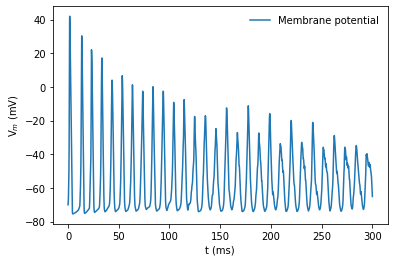

<IPython.core.display.Javascript object>

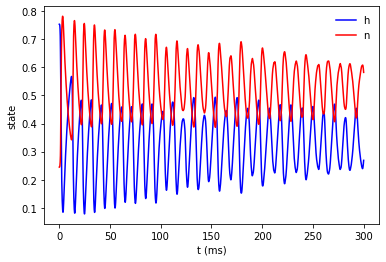

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

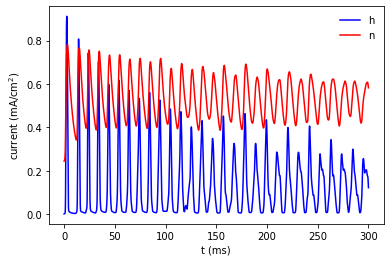

In [75]:
import numpy as np
from matplotlib import pyplot

vvecAArr=[]
kvecAArr=[]
mvecAArr=[]
hvecAArr=[]
nvecAArr=[]
for i in L1.sets:
    for cell in i.cells:
        checkCell = cell.axon(0.5)
        vvecAArr.append(h.Vector().record(checkCell._ref_v))
        kvecAArr.append(h.Vector().record(checkCell.k_ion._ref_ik))
        # nvecA = h.Vector().record(checkCell.na_ion._ref_ina)
        mvecAArr.append(h.Vector().record(checkCell.hh._ref_m))
        hvecAArr.append(h.Vector().record(checkCell.hh._ref_h))
        nvecAArr.append(h.Vector().record(checkCell.hh._ref_n))

tvec = h.Vector().record(h._ref_t)

h.finitialize(-70)
h.continuerun(300)

vvecMean = np.mean(vvecAArr,axis=0)
hvecMean = np.mean(hvecAArr,axis=0)
nvecMean = np.mean(nvecAArr,axis=0)
kvecMean = np.mean(kvecAArr,axis=0)

fig = pyplot.figure()
pyplot.plot(tvec, vvecMean, label="Membrane potential")
pyplot.xlabel('t (ms)')
pyplot.ylabel('V$_m$ (mV)')
pyplot.legend(frameon=False)

fig = pyplot.figure()
pyplot.plot(tvec, hvecMean, '-b', label='h')
pyplot.plot(tvec, nvecMean, '-r', label='n')
pyplot.xlabel('t (ms)')
pyplot.ylabel('state')
pyplot.legend(frameon=False)


fig = pyplot.figure()
pyplot.plot(tvec, kvecMean, '-b', label='h')
pyplot.plot(tvec, nvecMean, '-r', label='n')
pyplot.xlabel('t (ms)')
pyplot.ylabel('current (mA/cm$^2$)')
pyplot.legend(frameon=False)

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

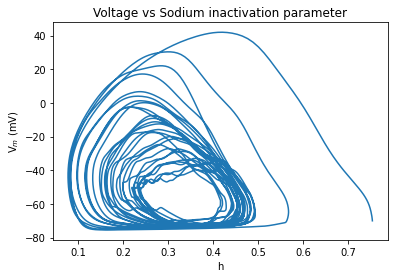

<IPython.core.display.Javascript object>

In [76]:
fig = pyplot.figure()
pyplot.plot(hvecMean, vvecMean, label="")
pyplot.xlabel('h')
pyplot.ylabel('V$_m$ (mV)')
pyplot.title('Voltage vs Sodium inactivation parameter')
pyplot.legend(frameon=False)

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>

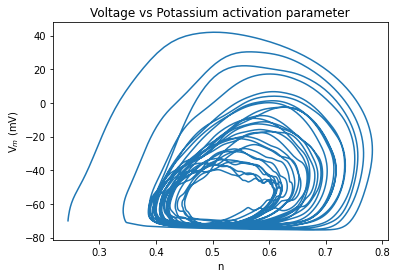

In [77]:
fig = pyplot.figure()
pyplot.plot(nvecMean, vvecMean, label="")
pyplot.xlabel('n')
pyplot.ylabel('V$_m$ (mV)')
pyplot.title('Voltage vs Potassium activation parameter')
pyplot.legend(frameon=False)

**Stage 8: Record & visualize the voltage values at each axon and dendride**

In [78]:
recording_cell = L1.sets[4].P1
print("The voltage at P1's axon:", recording_cell.axon(0.5).v)
axon_P1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
print("The voltage at P1's dendrite:", recording_cell.dend(0.5).v)
dend_P1 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(300 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P1), line_width=1,legend_label='P1 axon',line_color='black')
f.line(t, list(dend_P1), line_width=2,legend_label='P1 dend',line_color='red', line_dash='dashed')
plt2.show(f)

The voltage at P1's axon: -74.26387832265357
The voltage at P1's dendrite: -50.03089819147944


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [79]:
recording_cell = L1.sets[4].P2
axon_P2 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
dend_P2 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(300 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P2), line_width=1,legend_label='P2 axon',line_color='black')
f.line(t, list(dend_P2), line_width=2,legend_label='P2 dend',line_color='red', line_dash='dashed')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

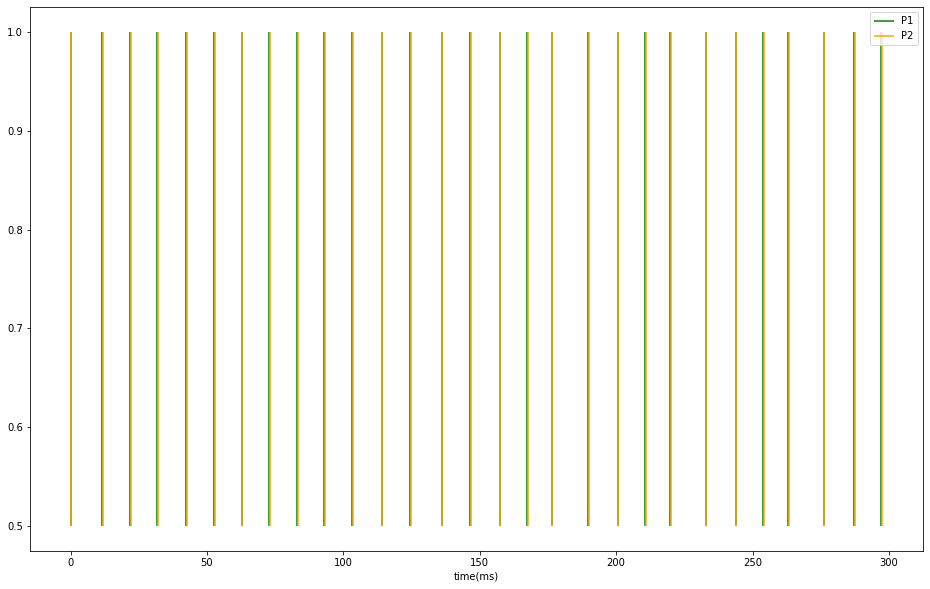

In [80]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(16,10))
for j in range(1):
  #for i,cell in enumerate(L1.sets[j].cells):
    plt1.vlines(L1.sets[j].cells[0].spike_times+(100*j), 0.5, 1,color=color[0]) # for P1
    plt1.vlines(L1.sets[j].cells[1].spike_times+(100*j), 0.5, 1, color=color[1])
plt1.xlabel('time(ms)')
plt1.legend(label)


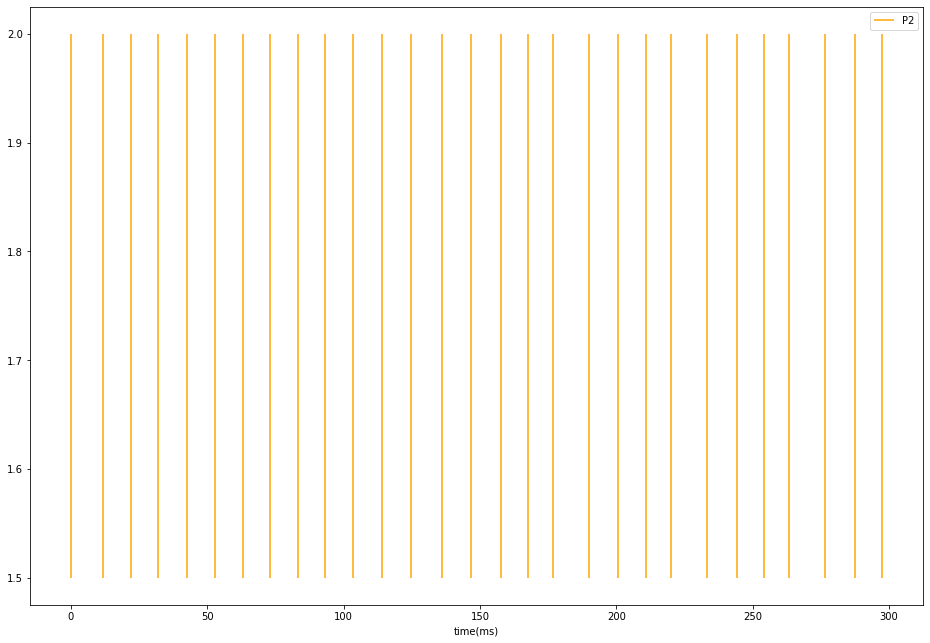

In [81]:
color=['green','orange']
label=['P2']
plt1.figure(figsize=(16,11))
for j in range(1):
  #for i,cell in enumerate(L1.sets[j].cells):
    plt1.vlines(L1.sets[j].cells[1].spike_times+(100*j), 1.5, 2,color=color[1]) # for P2
plt1.xlabel('time(ms)')
plt1.legend(label)

## Weights before learning

In [82]:
%load_ext google.colab.data_table
import pandas
P1_spike_times = list(L1.sets[0].cells[0].spike_times)
P2_spike_times = list(L1.sets[0].cells[1].spike_times)

padding = len(P1_spike_times) - len(P2_spike_times)
P2_spike_times.extend([0 for i in range(padding)]) if padding > 0 else P1_spike_times.extend([0 for i in range(-padding)])
# print(len(P1_spike_times), len(P2_spike_times))
data = {'P1 before learning': P1_spike_times, 'P2 before learning' : P2_spike_times}
pandas.DataFrame(data)

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


P1 before learning  P2 before learning
0                0.025               0.025
1               11.450              11.725
2               21.700              22.000
3               31.825              32.125
4               42.200              42.500
5               52.500              52.800
6               62.700              63.000
7               72.775              73.075
8               82.900              83.200
9               93.050              93.350
10             103.275             103.575
11             113.975             114.275
12             124.350             124.650
13             136.000             136.275
14             146.450             146.750
15             157.275             157.575
16             167.275             167.575
17             176.325             176.650
18             189.625             189.875
19             200.525             200.800
20             210.600             210.900
21             219.675             220.000
22             232.850             233.100
23             243.825             244.100
24             253.925             254.225
25             263.050             263.375
26             276.075             276.325
27             287.125             287.400
28             297.250             297.550

### **Before learning Firing rate**

In [83]:
fr_P1=[0 for i in range(len(L1.sets))]
fr_P2=[0 for i in range(len(L1.sets))]
for f in range(len(L1.sets)):
  t=list(L1.sets[f].cells[0].spike_times)
  #print("spikes of p1", t)
  t1=list(L1.sets[f].cells[1].spike_times)
  #print("spikes of p2", t1)
  fr_P1[f]=(len(t)/100)*1000
  fr_P2[f]=(len(t1)/100)*1000
#print("frequencies of P1 in each set", fr_P1)
#print("frequencies of P2 in each set", fr_P2)

c=[0 for i in range(size*2)]
for i in range(size):
  c[i*2]=fr_P1[i]
  c[i*2+1]=fr_P2[i]
print("Frequencies of each neuron before learning", c)

Frequencies of each neuron before learning [290.0, 290.0, 290.0, 290.0, 290.0, 290.0, 290.0, 290.0, 290.0, 290.0, 290.0, 290.0, 290.0, 290.0, 290.0, 290.0, 290.0, 290.0, 300.0, 290.0, 290.0, 290.0, 290.0, 290.0, 290.0, 290.0, 290.0, 290.0, 280.0, 280.0]


## Population Activity (Before Learning)

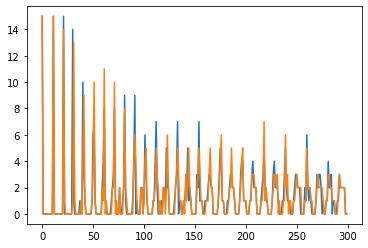

In [84]:
resolution = 1
import numpy as np
import math
M1_spike_times = [0 for i in range(0,300,resolution)]
M2_spike_times = [0 for i in range(0,300,resolution)]
for cell in L1.sets:
    for i in list(cell.cells[0].spike_times):
        M1_spike_times[math.floor(i)] += 1
    for i in list(cell.cells[1].spike_times):
        M2_spike_times[math.floor(i)] += 1
# M2_spike_times = np.array([list(cell.cells[1].spike_times) for cell in L1.sets])

import matplotlib.pyplot as plt
plt.plot(M1_spike_times)
plt.plot(M2_spike_times)

In [85]:
def generate_L_weight_delta(first, second):
    A_plus = 0.01
    A_minus = -0.0011
    tau_pre =20*ms
    tau_post =20*ms
    delta_t = [(second[iter] - first[iter]) for iter in range(min(len(first),len(second)))]
    delta_w_list = [A_plus*math.exp(-delta_t[iter]/tau_post) if delta_t[iter] >=0 else A_minus*math.exp(delta_t[iter]/tau_pre) for iter in range(min(len(first),len(second)))]  
    delta_w = sum(delta_w_list)
    return delta_w

### **Stage 9:Learning**

In [86]:
# epochs = 50
# import numpy as np
# import math
# out_1_1_data = []
# A_plus = 0.01      #0.2 to 2.5
# A_minus = -0.01
# tau_pre = 20*ms
# tau_post = 20*ms

# weights_rec = [[0 for i in range(epochs)] for j in range(len(L1.sets))]
# weights_rec_2 = [[0 for i in range(epochs)] for j in range(len(L1.sets))]
# L_weights_rec= [[0 for i in range(epochs)] for j in range(len(L1.sets)-1)]
# L_weights_rec_2= [[0 for i in range(epochs)] for j in range(len(L1.sets)-1)]

# for l in range(epochs):  
#     print("\niteration no is",l)
#     P1_data = []
#     print("\nmutual learning")
#     for i in range(len(L1.sets)):
#         h.continuerun(300 *ms)
#         out_1_1 = h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)
#         # print("Spike times P{0}".format(1+i*2), list(L1.sets[i].P1.spike_times))
#         spike_1_1 = list(L1.sets[i].P1.spike_times)
#         out_1_2 = h.Vector().record(L1.sets[i].P2.dend(0.5)._ref_v)
#         spike_1_2 = list(L1.sets[i].P2.spike_times)
#         # print("Spike times P{0}".format(2+i*2), list(L1.sets[i].P2.spike_times))
#         t = h.Vector().record(h._ref_t)
#         h.finitialize(-70 * mV)
        
#         for k in range(1,3):
#             delta_t = [(spike_1_2[iter] - spike_1_1[iter]) for iter in range(min(len(spike_1_1),len(spike_1_2)))]
#             delta_w_list = [A_plus*math.exp(-delta_t[iter]/tau_post) if delta_t[iter] >=0.24 else A_minus*math.exp(delta_t[iter]/tau_pre) for iter in range(min(len(spike_1_1),len(spike_1_2)))]
#             delta_w = sum(delta_w_list)
#             exec(f"L1.sets[i].nc{k}.weight[0] += delta_w")         
#         P1_data.append(list(out_1_1))
#         print("weight:", L1.sets[i].nc1.weight[0])
#         weights_rec[i][l] = L1.sets[i].nc1.weight[0]
#         weights_rec_2[i][l] = L1.sets[i].nc2.weight[0]    



# #Lateral Learning
#     print("\tlateral learning")
#     for i in range(len(L1.sets)-1):
#       h.continuerun(300 *ms)
#       out_1_1 = h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)
#       print("Spike times P{0}".format(1+2*i), list(L1.sets[i].P1.spike_times))
#       spike_1_1 = list(L1.sets[i].P1.spike_times)
#       out_2_1 = h.Vector().record(L1.sets[i+1].P1.axon(0.5)._ref_v)
#       print("Spike times P{0}".format(3+2*i), list(L1.sets[i+1].P1.spike_times))
#       spike_2_1 = list(L1.sets[i+1].P1.spike_times)
#       h.finitialize(-70 * mV)

#       # change the deltas
      
#       L1.netConArr[i][0].weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)
#       L1.netConArr[i][1].weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)

#       # Logging work

#       print(L1.netConArr[i][0].weight[0])
#       L_weights_rec[i][l] = L1.netConArr[i][0].weight[0]
#       L_weights_rec[i][l] = L1.netConArr[i][1].weight[0]
#       # exec(f"L1.nc11_{i}.weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)")
#       # exec(f"L1.nc12_{i}.weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)")
#       # exec(f"L1.nc11_{i}.weight[0] += generate_L_weight_delta(spike_M1_data[i], spike_M1_data[i+1])")
#       # exec(f"L1.nc12_{i}.weight[0] += generate_L_weight_delta(spike_M1_data[i+1], spike_M1_data[i])")
#       # print("lateral weight is : ",L1.nc11_0.weight[0])  
#       # L_weights_rec[i][l] = L1.nc11_0.weight[0]
#       # L_weights_rec_2[i][l]=L1.nc12_i.weight[0] 
#       # exec(f"print(L1.nc11_{i}.weight[0])")
#       # exec(f"L_weights_rec[i][l]=L1.nc11_{i}.weight[0]")
#       # exec(f"L_weights_rec_2[i][l]=L1.nc12_{i}.weight[0]")

In [87]:
import sys, time
tick = time.time()
epochs = 30
weight_data = []

out = display(progress(0, epochs), display_id=True)

for l in range(epochs):
    #print("iteration no is",l)
    out.update(progress(l, epochs))    
    # print("\nmutual learning")
    P1_axon_data = []
    P1_dend_data = []
    P2_axon_data = []
    P2_dend_data = []
    M1_axon_data = []
    M1_dend_data = []
    M2_axon_data = []
    M2_dend_data = []
    G1_axon_data = []
    G1_dend_data = []
    G2_axon_data = []
    G2_dend_data = []
    P1_spike_times = []
    P2_spike_times = []
    M1_spike_times = []
    M2_spike_times = []
    G1_spike_times = []
    G2_spike_times = []

    h.finitialize(-70* mV)
    h.continuerun(300*ms)
    t = h.Vector().record(h._ref_t)
    
    for i in range(len(L1.sets)):
        P1_axon_data.append(list(h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)))
        P1_dend_data.append(list(h.Vector().record(L1.sets[i].P1.dend(0.5)._ref_v)))
        P1_spike_times.append(list(L1.sets[i].P1.spike_times))
        P2_axon_data.append(list(h.Vector().record(L1.sets[i].P2.axon(0.5)._ref_v)))
        P2_spike_times.append(list(L1.sets[i].P2.spike_times))
        P2_dend_data.append(list(h.Vector().record(L1.sets[i].P2.dend(0.5)._ref_v)))
   
    # h.finitialize(-70 * mV)

    for i in range(len(L1.sets)):
        # 2-coupled STDP-based learning
        L1.sets[i].nc1.weight[0] += generate_L_weight_delta(P1_spike_times[i], P2_spike_times[i])
        # logging
        # print("P1_axon", P1_spike_times[i], P2_spike_times[i])
        L1.sets[i].nc2.weight[0] += generate_L_weight_delta(P2_spike_times[i], P1_spike_times[i])
        
    # do a proper logging function
    weight_data.append(L1.sets[0].nc1.weight[0])


    #Lateral Learning
    for i in range(len(L1.sets)-1):
        # 2-coupled part
        L1.netConArr[i][0].weight[0] += generate_L_weight_delta(P1_spike_times[i], P1_spike_times[i+1])
        L1.netConArr[i][1].weight[0] += generate_L_weight_delta(P1_spike_times[i+1], P1_spike_times[i])
    

out.update(progress(epochs, epochs))    
tock = time.time()
print("The time it took to learn", tock-tick, "seconds")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The time it took to learn 10.202793598175049 seconds


In [88]:
l1=[]
l2=[]
for i in range(size):
  l1.append(L1.sets[i].nc1.weight[0])
  l2.append(L1.sets[i].nc2.weight[0])
print(l1)
print(l2)

[9.36078533844034, 10.35272368077451, 9.765881175059466, 9.756580023457559, 10.126536935033995, 10.254724643396319, 10.034646017539766, 8.042074958526314, 10.076691955577935, 9.795907332021407, 9.983489386454698, 10.439507424451634, 9.981435280854992, 10.816256071140392, 8.771923560264792]
[0.3267187450548279, 0.8984070758107356, 0.6285464899169709, 0.25507378389807633, 0.22584554129621803, 0.4312565787927582, 0.1611595749995022, -0.04533012529068648, 0.15002141188006465, 0.29218484860184724, 0.4296473904688855, 0.6745983289195867, 0.31672010933212463, 1.3823194499129605, -0.05868715031312163]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

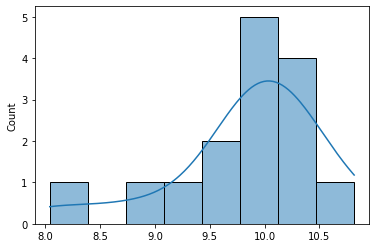

In [89]:
sb.histplot(l1, kde=True)

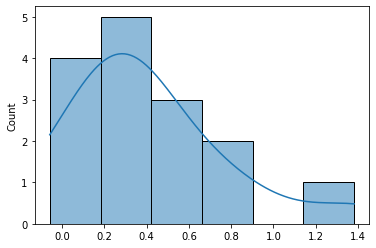

In [90]:
sb.histplot(l2, kde=True)

In [91]:
print(P1_spike_times)

[[0.025000000100000003, 11.52500000009988, 22.000000000099284, 31.525000000098743, 41.77500000010094, 52.00000000010326, 59.000000000104855, 81.42500000010995, 92.17500000011239, 102.07500000011464, 112.35000000011698, 120.22500000011877, 130.50000000011823, 137.55000000011182, 149.0000000001014, 163.4250000000883, 173.80000000007885, 180.9000000000724, 192.325000000062, 205.3000000000502, 217.00000000003956, 223.85000000003333, 235.45000000002278, 244.02500000001498, 249.97500000000957, 260.0750000000004, 267.099999999994, 278.57499999998356, 287.2249999999757, 293.49999999997], [0.025000000100000003, 11.425000000099885, 21.100000000099335, 29.97500000009883, 36.85000000009982, 52.12500000010329, 59.30000000010492, 71.37500000010766, 80.02500000010963, 90.25000000011195, 98.05000000011373, 108.35000000011607, 115.35000000011766, 126.82500000012027, 141.35000000010837, 151.650000000099, 158.7000000000926, 170.17500000008215, 183.2000000000703, 194.87500000005969, 201.65000000005352, 21

In [92]:
# print(sum([len(list(cell.cells[0].spike_times)) for cell in L1.sets])/(len(L1.sets)*300))
# print(sum([len(list(cell.cells[1].spike_times)) for cell in L1.sets])/(len(L1.sets)*300))


In [93]:
## TODO: Check what kind of distribution is followed by the output

## Weights after learning

In [94]:
%load_ext google.colab.data_table
import pandas
P1_spike_times = list(L1.sets[0].cells[0].spike_times)
P2_spike_times = list(L1.sets[0].cells[1].spike_times)

padding = len(P1_spike_times) - len(P2_spike_times)
P2_spike_times.extend([0 for i in range(padding)]) if padding > 0 else P1_spike_times.extend([0 for i in range(-padding)])
# print(len(P1_spike_times), len(P2_spike_times))
data = {'P1 before learning': P1_spike_times, 'P2 before learning' : P2_spike_times}
pandas.DataFrame(data)

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


P1 before learning  P2 before learning
0                0.025               0.025
1               11.525              11.750
2               22.000              22.225
3               31.525              31.775
4               41.775              42.000
5               52.000              52.225
6               59.000              59.275
7               81.425              81.550
8               92.175              92.400
9              102.075             102.300
10             112.350             112.575
11             120.225             120.475
12             130.500             130.750
13             137.550             137.825
14             149.000             149.250
15             163.425             163.600
16             173.800             174.025
17             180.900             181.175
18             192.325             192.575
19             205.300             205.500
20             217.000             217.225
21             223.850             224.125
22             235.450             235.725
23             244.025             244.275
24             249.975             250.350
25             260.075             260.250
26             267.100             267.375
27             278.575             278.825
28             287.225             287.475
29             293.500             293.825

In [95]:
print(weights)

[0.91326284 1.51755467 1.22524769 0.88794072 0.90699514 1.10475341
 0.83169984 0.43404924 0.83374552 0.93399518 1.07642453 1.32485511
 0.97448468 1.9925995  0.44296773 0.51067497 0.86566101 1.08041855
 1.63592384 0.50921576 1.62875053 0.99528526 1.41276763 0.72958935
 1.00778162 1.33007447 1.26391083 2.07508643 2.1399906 ]


**Stage 8: Record & visualize the voltage values at each axon and dendride after learning**

In [96]:
recording_cell = L1.sets[2].P1
dend_P1 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
axon_P1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
t = h.Vector().record(h._ref_t)
print(recording_cell.axon(0.5).v)
h.finitialize(-70 * mV)
h.continuerun(200 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P1), line_width=1,legend_label='P1 axon',line_color='black')
f.line(t, list(dend_P1), line_width=2,legend_label='P1 dend',line_color='red', line_dash='dashed')
plt2.show(f)

-69.2967922583344


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [97]:
recording_cell = L1.sets[2].P2
axon_P1 = h.Vector().record(recording_cell.soma(0.5)._ref_v)
dend_P1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(100 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_P1), line_width=1,legend_label='P2 axon',line_color='black')
f.line(t, list(dend_P1), line_width=2,legend_label='P2 dend',line_color='red', line_dash='dashed')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [98]:
# print(weight_data)
f = plt2.figure(x_axis_label='epochs')
x = [i for i in range(epochs)]
f.line(x, weight_data, line_width=1, line_color='black')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

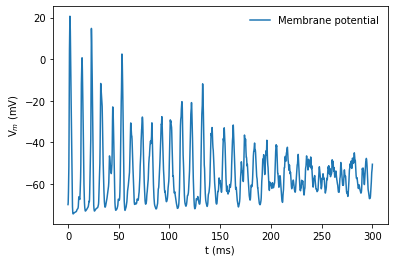

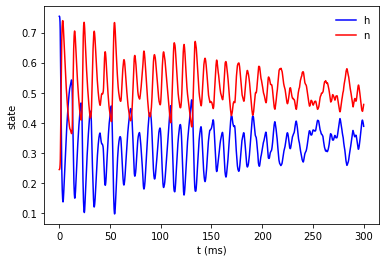

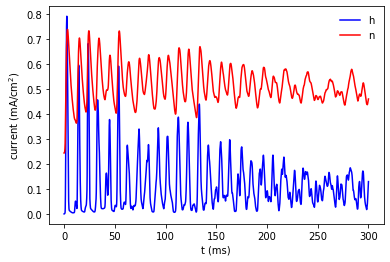

In [99]:
import numpy as np
from matplotlib import pyplot

vvecAArr=[]
kvecAArr=[]
mvecAArr=[]
hvecAArr=[]
nvecAArr=[]
for i in L1.sets:
    for cell in i.cells:
        checkCell = cell.axon(0.5)
        vvecAArr.append(h.Vector().record(checkCell._ref_v))
        kvecAArr.append(h.Vector().record(checkCell.k_ion._ref_ik))
        # nvecA = h.Vector().record(checkCell.na_ion._ref_ina)
        mvecAArr.append(h.Vector().record(checkCell.hh._ref_m))
        hvecAArr.append(h.Vector().record(checkCell.hh._ref_h))
        nvecAArr.append(h.Vector().record(checkCell.hh._ref_n))

tvec = h.Vector().record(h._ref_t)

h.finitialize(-70)
h.continuerun(300)

vvecMean = np.mean(vvecAArr,axis=0)
hvecMean = np.mean(hvecAArr,axis=0)
nvecMean = np.mean(nvecAArr,axis=0)
kvecMean = np.mean(kvecAArr,axis=0)

fig = pyplot.figure()
pyplot.plot(tvec, vvecMean, label="Membrane potential")
pyplot.xlabel('t (ms)')
pyplot.ylabel('V$_m$ (mV)')
pyplot.legend(frameon=False)

fig = pyplot.figure()
pyplot.plot(tvec, hvecMean, '-b', label='h')
pyplot.plot(tvec, nvecMean, '-r', label='n')
pyplot.xlabel('t (ms)')
pyplot.ylabel('state')
pyplot.legend(frameon=False)


fig = pyplot.figure()
pyplot.plot(tvec, kvecMean, '-b', label='h')
pyplot.plot(tvec, nvecMean, '-r', label='n')
pyplot.xlabel('t (ms)')
pyplot.ylabel('current (mA/cm$^2$)')
pyplot.legend(frameon=False)

No handles with labels found to put in legend.


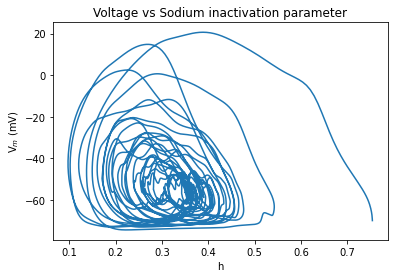

In [100]:
fig = pyplot.figure()
pyplot.plot(hvecMean, vvecMean, label="")
pyplot.xlabel('h')
pyplot.ylabel('V$_m$ (mV)')
pyplot.title('Voltage vs Sodium inactivation parameter')
pyplot.legend(frameon=False)

No handles with labels found to put in legend.


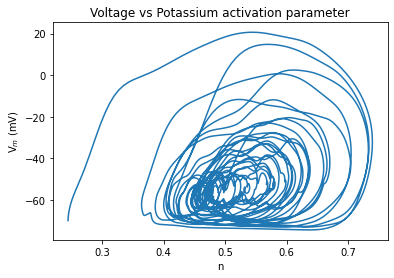

In [101]:
fig = pyplot.figure()
pyplot.plot(nvecMean, vvecMean, label="")
pyplot.xlabel('n')
pyplot.ylabel('V$_m$ (mV)')
pyplot.title('Voltage vs Potassium activation parameter')
pyplot.legend(frameon=False)

## Population Activity

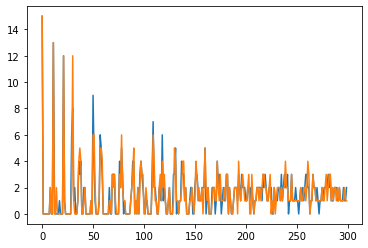

In [102]:
resolution = 1
import numpy as np
import math
M1_spike_times = [0 for i in range(0,300,resolution)]
M2_spike_times = [0 for i in range(0,300,resolution)]
for cell in L1.sets:
    for i in list(cell.cells[0].spike_times):
        M1_spike_times[math.floor(i)] += 1
    for i in list(cell.cells[1].spike_times):
        M2_spike_times[math.floor(i)] += 1
# M2_spike_times = np.array([list(cell.cells[1].spike_times) for cell in L1.sets])

import matplotlib.pyplot as plt
plt.plot(M1_spike_times)
plt.plot(M2_spike_times)

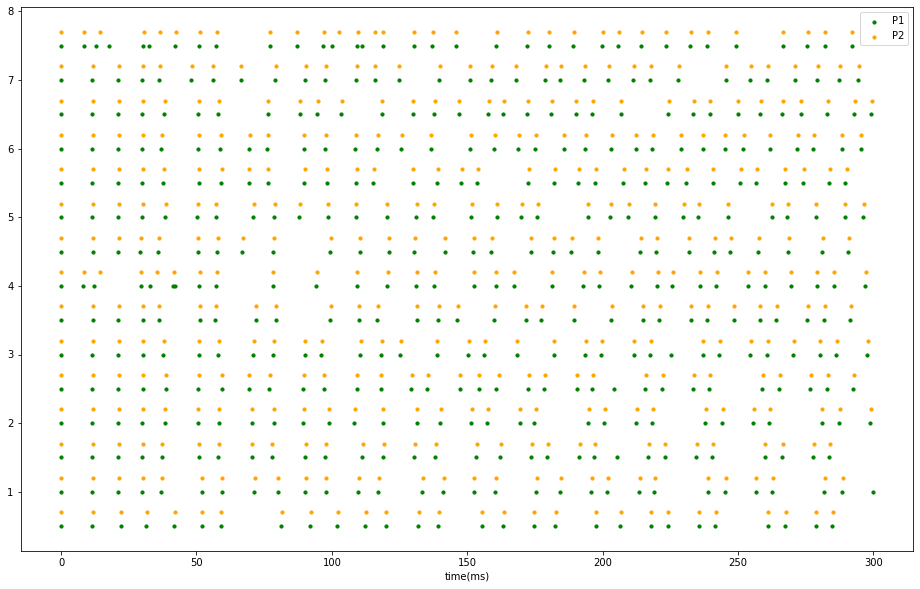

In [103]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(16,10))
for j in range(len(L1.sets)):
  #for i,cell in enumerate(L1.sets[j].cells):
    plt1.scatter(L1.sets[j].cells[0].spike_times, [0.5 + 0.5*j for i in range(len(L1.sets[j].cells[0].spike_times))], s=10,color=color[0]) # for P1
    plt1.scatter(L1.sets[j].cells[1].spike_times, [0.7 + 0.5*j for i in range(len(L1.sets[j].cells[1].spike_times))], s=10, color=color[1])
plt1.xlabel('time(ms)')
plt1.legend(label)

In [104]:
# count, bins, ignored = plt1.hist(weights_rec[0], 10)
# # Plot the distribution curve
# # plt1.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),       linewidth=3, color='y')
# plt1.legend(label)
# plt1.xlabel('weights')
# plt1.ylabel('frequency')
# plt1.show()
# print(weights_rec[0])

In [105]:
# f = plt2.figure(x_axis_label='epoch', y_axis_label='weights')
# x = [i for i in range(len(L_weights_rec[0]))]
# f.line(x, L_weights_rec[3], line_width=1, legend_label='nc11', line_color='blue')
# f.line(x, L_weights_rec_2[0], line_width=2, legend_label='nc12', line_color='red', line_dash='dotted')
# plt2.show(f)

### **Raster scan for short intervals**

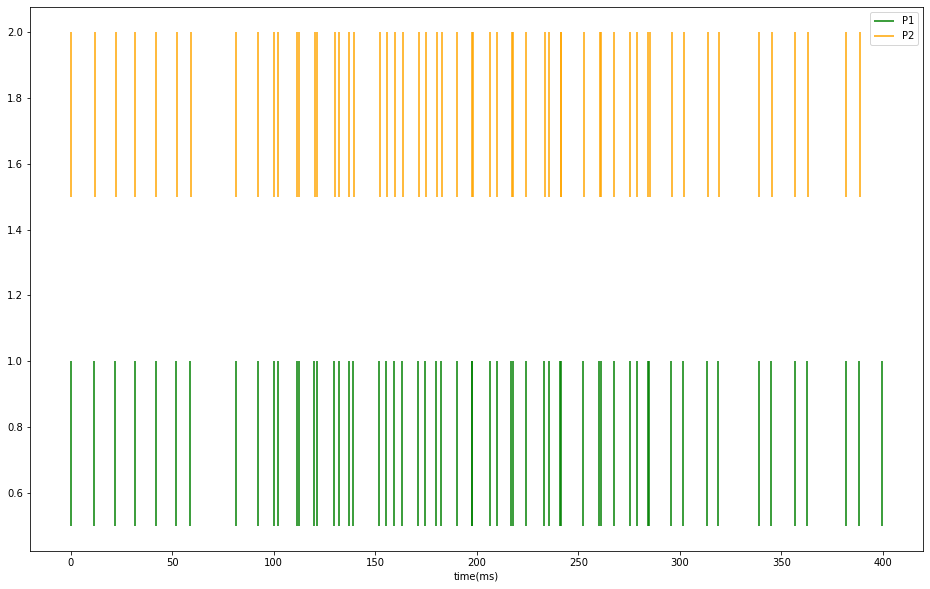

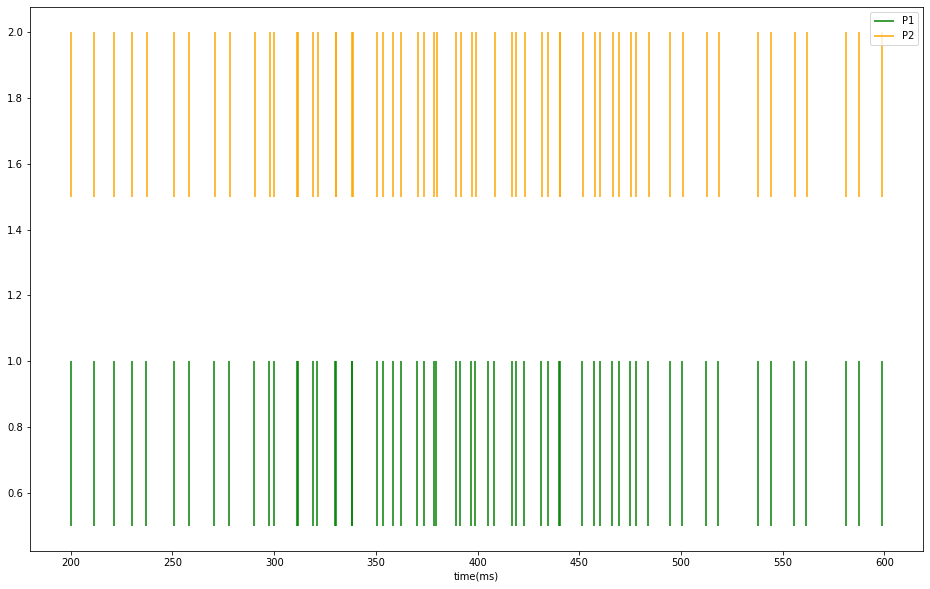

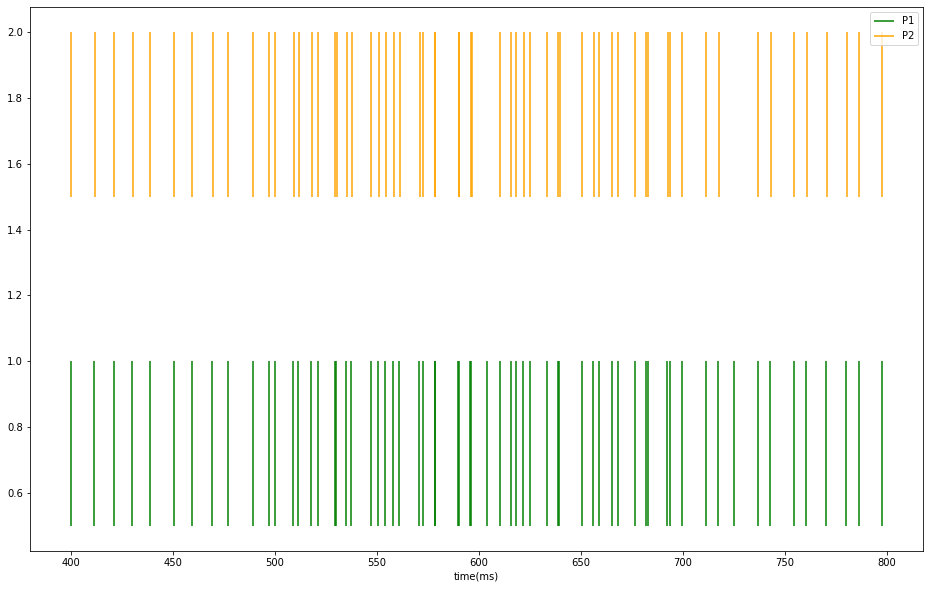

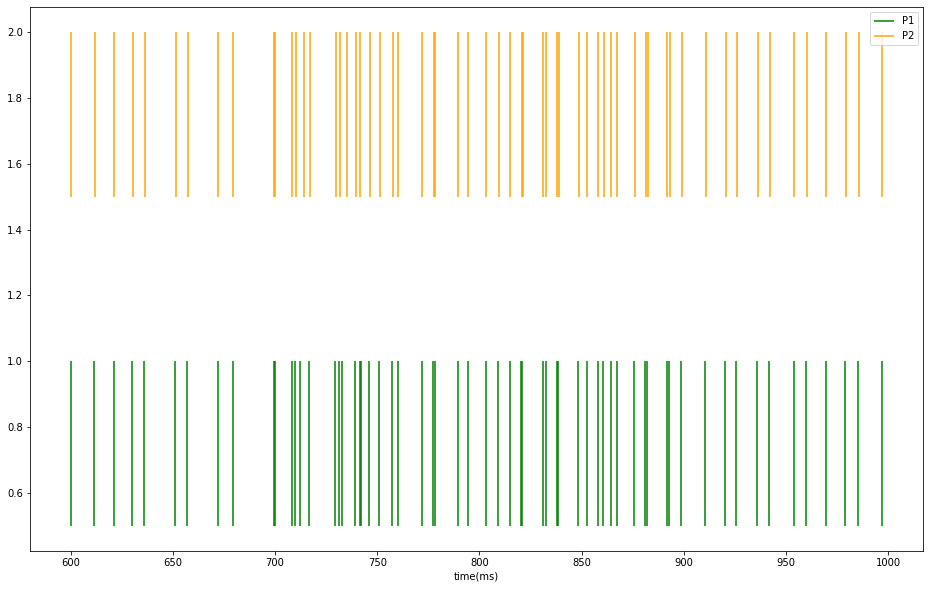

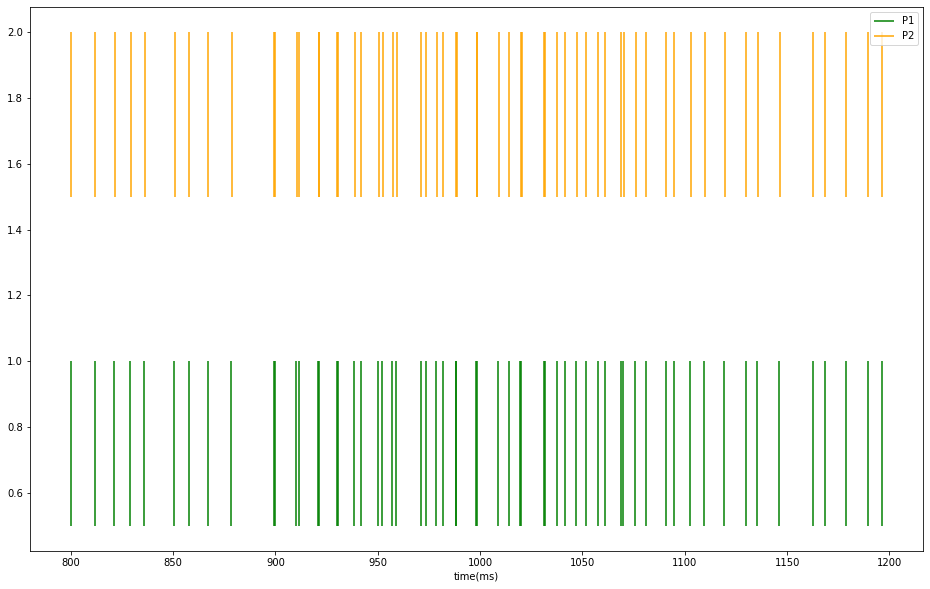

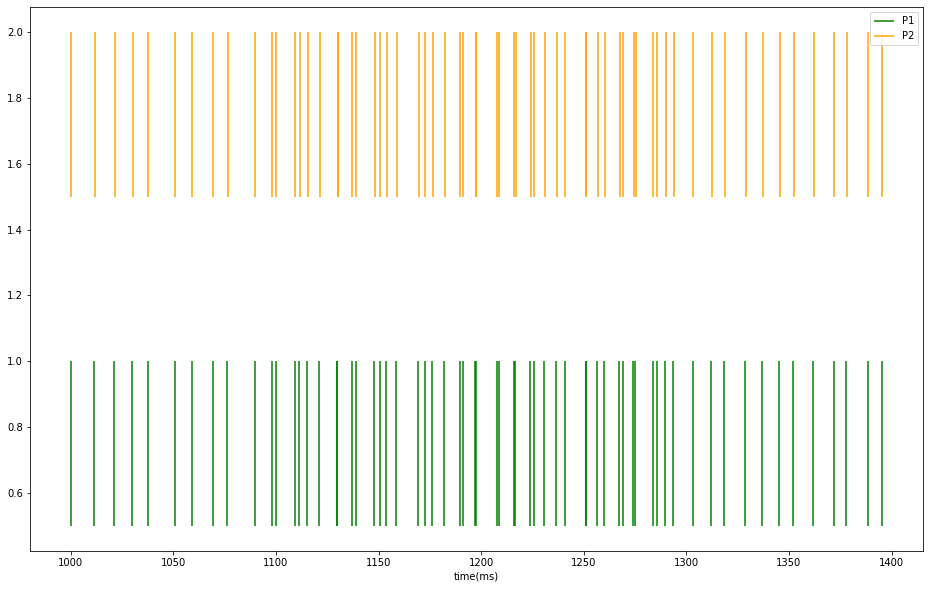

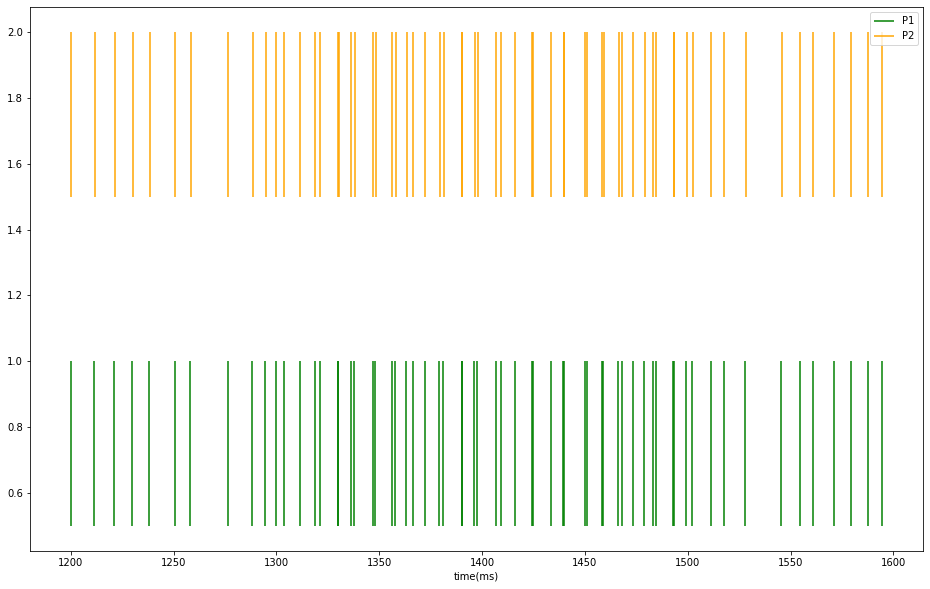

In [106]:
interval=2 #no.of pairs for each raster scan(if interval is 1 each pair would be displayed individually)
start=0
end=interval
lis=int(size/end)
for k in range(lis):
  color=['green','orange']
  label=['P1','P2']
  plt1.figure(figsize=(16,10))
  for j in range(start,end):
      for i,cell in enumerate(L1.sets[j].cells):
          plt1.vlines(cell.spike_times+(100*j), i + 0.5, i + 1,color=color[i])
  plt1.xlabel('time(ms)')
  plt1.legend(label)
  start=end
  end=end+interval


[0.025000000100000003, 11.52500000009988, 22.025000000099283, 31.525000000098743, 41.82500000010095, 51.95000000010325, 58.97500000010485, 81.40000000010994, 92.10000000011237, 102.02500000011463, 112.27500000011696, 119.9250000001187, 131.90000000011696, 139.17500000011034, 155.4000000000956, 163.25000000008845, 174.60000000007813, 182.47500000007096, 197.57500000005723, 206.47500000004914, 217.8500000000388, 224.05000000003315, 235.62500000002262, 241.3750000000174, 260.97499999999957, 267.37499999999375, 278.7499999999834, 284.84999999997785]
[0.025000000100000003, 11.52500000009988, 22.025000000099283, 31.525000000098743, 41.82500000010095, 51.95000000010325, 58.97500000010485, 81.40000000010994, 92.10000000011237, 102.02500000011463, 112.27500000011696, 119.9250000001187, 131.90000000011696, 139.17500000011034, 155.4000000000956, 163.25000000008845, 174.60000000007813, 182.47500000007096, 197.57500000005723, 206.47500000004914, 217.8500000000388, 224.05000000003315, 235.6250000000

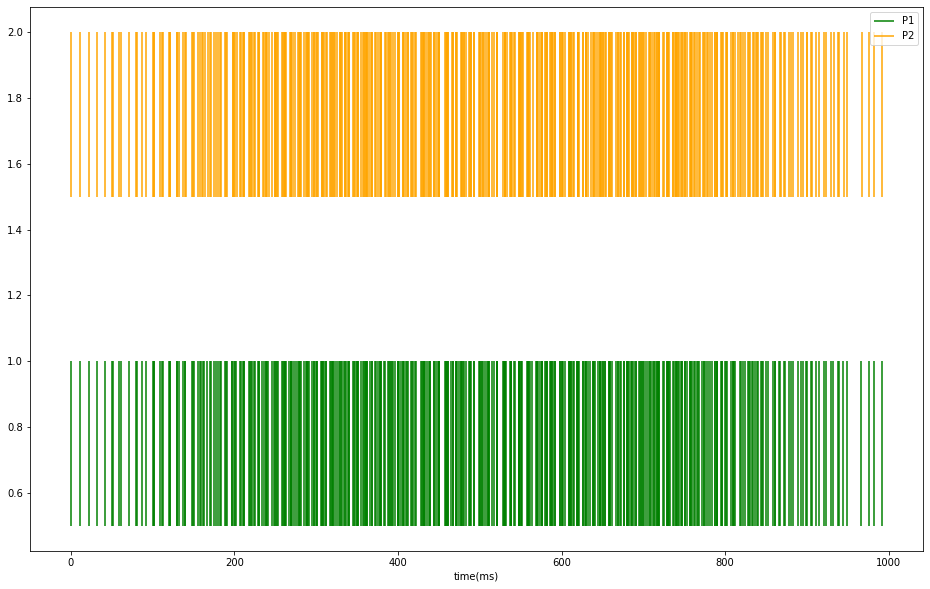

In [107]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(16,10))
for j in range(given_input_from_user):
    for i,cell in enumerate(L1.sets[j].cells):
        plt1.vlines(cell.spike_times+(50*j), i + 0.5, i + 1,color=color[i])
plt1.xlabel('time(ms)')
plt1.legend(label)
t1=list(L1.sets[0].cells[0].spike_times)
t2=list(L1.sets[0].cells[0].spike_times)
print(t1)
print(t2)

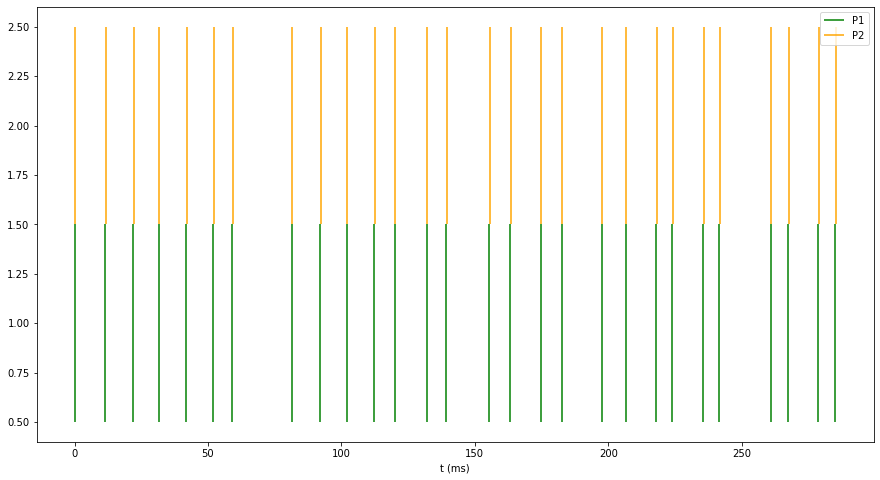

In [108]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(15,8))
for i,cell in enumerate(L1.sets[0].cells):
    plt1.vlines(cell.spike_times, i + 0.5, i + 1.5,color=color[i],label=label[i])
plt1.xlabel('t (ms)')
plt1.legend()
plt1.show()

In [109]:
%load_ext google.colab.data_table
import pandas
P1_spike_times = list(L1.sets[0].cells[0].spike_times)
P2_spike_times = list(L1.sets[0].cells[1].spike_times)

padding = len(P1_spike_times) - len(P2_spike_times)
P2_spike_times.extend([0 for i in range(padding)]) if padding > 0 else P1_spike_times.extend([0 for i in range(-padding)])
# print(len(P1_spike_times), len(P2_spike_times))
data = {'P1 before learning': P1_spike_times, 'P2 before learning' : P2_spike_times}
pandas.DataFrame(data)

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


P1 before learning  P2 before learning
0                0.025               0.025
1               11.525              11.750
2               22.025              22.250
3               31.525              31.775
4               41.825              42.050
5               51.950              52.175
6               58.975              59.250
7               81.400              81.525
8               92.100              92.325
9              102.025             102.250
10             112.275             112.500
11             119.925             120.175
12             131.900             132.125
13             139.175             139.425
14             155.400             155.575
15             163.250             163.500
16             174.600             174.825
17             182.475             182.725
18             197.575             197.750
19             206.475             206.725
20             217.850             218.075
21             224.050             224.350
22             235.625             235.800
23             241.375             241.725
24             260.975             261.100
25             267.375             267.675
26             278.750             278.925
27             284.850             285.150

In [110]:
rmn=2*size-1
final_weights=[0]*n
labels=range(2*size-1)
initial_weights =weights[0:n]
for i in range(size):
  final_weights[i]=weights_rec[i][-1]
"""
for i in range(size,2*size-1):
  final_weights.insert(i,weights[i])
"""
for i in range(size-1):
  final_weights[i+size]= L_weights_rec[i][-1]

#final_weights=final_weights[0:n]  

print(initial_weights)
print(final_weights)

plt1.figure(figsize=(16,9))
x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars
 
fig, ax = plt1.subplots()
rects1 = ax.bar(x - width/2,initial_weights, width, label='initial')
rects2 = ax.bar(x + width/2,final_weights , width, label='final')
 
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('weights')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid()
fig.tight_layout()
for i, v in enumerate(final_weights):
    ax.text(i,v, str(round(v,3)), color = 'blue', fontweight = 'bold')
for i, v in enumerate(initial_weights):
    ax.text(i-0.23,v, str(round(v,3)), color = 'red')
plt1.show()

NameError: ignored

### **After learning firing rate**

In [ ]:
fr_P1_1=[0 for i in range(len(L1.sets))]
fr_P2_1=[0 for i in range(len(L1.sets))]
c_1=[0 for i in range(size*2)]
for f in range(len(L1.sets)):
  t=list(L1.sets[f].cells[0].spike_times)
  t1=list(L1.sets[f].cells[1].spike_times)
  fr_P1_1[f]=(len(t)/100)*1000  # length of t= no.of spikes
  fr_P2_1[f]=(len(t1)/100)*1000
#print("frequencies of P1 in each set", fr_P1_1)
#print("frequencies of P2 in each set", fr_P2_1)
for i in range(size):
  c_1[i*2]=fr_P1_1[i]
  c_1[i*2+1]=fr_P2_1[i]
print("Frequencies of each neuron after learning", c_1)

In [ ]:
neuron_name=[0 for i in range(size*2)]
import plotly.graph_objects as go

for i in range(2*size):
  neuron_name[i]="p{0}".format(i+1)
print(neuron_name)

fig = go.Figure()

fig.add_trace(go.Scatter(x=neuron_name, y=c, marker=dict(color="crimson", size=9), mode="markers", name="Before Lering"))


fig.add_trace(go.Scatter(x=neuron_name, y=c_1, marker=dict(color="green", size=9), mode="markers", name="After Learning"))

fig.update_layout(title="firing rate", xaxis_title="neuron", yaxis_title="Frequency")

print("Frequencies of each neuron before learning", c)
print("Frequencies of each neuron after learning", c_1)

fig.show()

In [ ]:
label=['histogram']
n=size
labels=range(2*size)

plt1.figure(figsize=(16,9))
x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars
 
fig, ax = plt1.subplots()
rects1 = ax.bar(x - width/2,c, width, label='Before Learning')
rects1 = ax.bar(x + width/2,c_1, width, label='After Learning')
 
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('frequency in HZ')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid()
fig.tight_layout()
for i, v in enumerate(c):
    ax.text(i,v, str(round(v,3)), color = 'blue', fontweight = 'bold')
    for i, v in enumerate(c_1):
      ax.text(i,v, str(round(v,3)), color = 'green', fontweight = 'bold')
plt1.show()

count, bins, ignored = plt1.hist(c, 20)
plt1.legend(label)
plt1.xlabel('firing rate')
plt1.ylabel('no of neurons')
plt1.show()

count, bins, ignored = plt1.hist(c_1, 20)
plt1.legend(label)
plt1.xlabel('firing rate')
plt1.ylabel('no of neurons')
plt1.show()


In [ ]:
"""
from scipy.stats import skew
plt1.hist(weights, bins=10)
print(weights)
print(skew(weights))
plt1.show()
"""